In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# Define paths
project_dir = os.path.dirname(os.path.dirname(os.path.abspath('EDA')))
file_path = os.path.join(project_dir, 'EDA')

In [ ]:
excel_file = pd.ExcelFile(f'{file_path}/full_patients_sim.xlsx')
dfs = []

In [ ]:
# columns to delete
to_delete = ['UV', 'R', 'IL1720', 'GF20', 'D20', 'D2A', 'TIME_UVB', 'T_MIN', 'R20', 'TNF20', 'DC_ACT', 'T2', 'N', 'DC_MIN', 'DESQ', 'TOTC_MIN', 'TOTC_MAX', 'D_MIN', 'D_MAX', 'DC_MAX', 'T_MAX']
# clean and format each sheet
for sheet in excel_file.sheet_names:
  df = pd.read_excel(excel_file, sheet_name=sheet)
  df.columns = [c.replace("'", "").upper().replace(" ", "_") for c in list(df.columns)]
  for col in list(df.columns):
    if col.startswith("DC_STIM") or col  in to_delete:
      df = df.drop([col], axis=1)
  dfs.append(df)

In [ ]:
def identify_flare_weeks(df):
    df_pasi = df[df['ACTUAL_PASI'].notna()]
    clusters = df_pasi.index.to_series().diff().fillna(1).abs() > 1
    cluster_starts = df_pasi.index[clusters].tolist()

    # Include the start of the first cluster
    if len(cluster_starts) == 0 or (len(cluster_starts) > 0 and cluster_starts[0] != df_pasi.index[0]):
        cluster_starts.insert(0, df_pasi.index[0])

    flare_weeks = []
    for i in range(1, len(cluster_starts)):
        week_start = cluster_starts[i-1]
        week_end = cluster_starts[i]  # Include the beginning of the next cluster

        if df.loc[week_end, 'ABNORMAL_READING'] == 1:
            flare_weeks.append(i)

    # Check last cluster separately
    if len(cluster_starts) > 0:
        last_week_start = cluster_starts[-1]
        last_week_end = df_pasi.index[-1]
        if df.loc[last_week_end, 'ABNORMAL_READING'] == 1:
            flare_weeks.append(len(cluster_starts)-1)

    return flare_weeks

In [ ]:
all_flare_weeks = []
patients_with_flares = 0
for i, df in enumerate(dfs):
    flare_weeks = identify_flare_weeks(df)
    all_flare_weeks.extend(flare_weeks)  # Collect all flare weeks in a flat list
    if len(flare_weeks) != 0:
      patients_with_flares += 1

In [ ]:
# Assuming all_flare_weeks contains week numbers with flares and does not start at 0
if all_flare_weeks:  # Check if the list is not empty
    min_week = min(all_flare_weeks)
    max_week = max(all_flare_weeks)

    # Plot a histogram of flare weeks
    plt.figure(figsize=(12, 6))
    # Setting the bins to start from min_week to max_week + 1
    plt.hist(all_flare_weeks, bins=range(min_week, max_week + 2), edgecolor='black', alpha=0.7)
    plt.title('Distribution of Flare Weeks Across All Patients')
    plt.xlabel('Week Number')
    plt.ylabel('Count of Flare Weeks')
    plt.xticks(range(min_week, max_week + 1))  # Set ticks from the minimum week number to the maximum
    plt.grid(True)
    plt.show()
else:
    print("No flare weeks data available.")

In [ ]:
def get_flare_intervals(df):
    """
    Identifies weeks based on clusters of actual PASI readings and determines if they are flare weeks.
    Returns a list of tuples for each week, where each tuple contains:
    - start index of the week
    - end index of the week
    - boolean indicating if it is a flare week (True if flare, False otherwise)
    """
    df_pasi = df[df['ACTUAL_PASI'].notna()]

    # Identify the start index of each cluster
    clusters = df_pasi.index.to_series().diff().fillna(1).abs() > 1
    cluster_starts = df_pasi.index[clusters].tolist()

    # Include the start of the first cluster
    if len(cluster_starts) == 0 or (len(cluster_starts) > 0 and cluster_starts[0] != df_pasi.index[0]):
        cluster_starts.insert(0, df_pasi.index[0])

    # Collect weeks and check if they are flare weeks
    week_intervals = []
    for i in range(1, len(cluster_starts)):
        week_start = cluster_starts[i-1]
        week_end = cluster_starts[i]  # Include the beginning of the next cluster

        # Determine if the week is a flare week
        is_flare = df.loc[week_end, 'ABNORMAL_READING'] == 1
        week_intervals.append((week_start, week_end, is_flare))

    # Check last cluster separately
    if len(cluster_starts) > 0:
        last_week_start = cluster_starts[-1]
        last_week_end = df_pasi.index[-1]
        last_week_flare = df.loc[last_week_end, 'ABNORMAL_READING'] == 1
        week_intervals.append((last_week_start, last_week_end, last_week_flare))

    return week_intervals
def extract_week_changes(df, variable):
    """Extract changes in the specified variable from the start to the end of each week."""
    week_info = get_flare_intervals(df)
    week_changes = {}  # This will store changes by week number: {week_number: [list_of_changes]}

    # Assuming each interval is a unique week and assigning week numbers sequentially
    for index, (start, end, is_flare) in enumerate(week_info):
        week_number = index + 1  # Start week numbering at 1
        if not df.loc[start:end, variable].empty:
            change = df.loc[end, variable] - df.loc[start, variable]
            if week_number not in week_changes:
                week_changes[week_number] = {'flare': [], 'non_flare': []}
            if is_flare:
                week_changes[week_number]['flare'].append(change)
            else:
                week_changes[week_number]['non_flare'].append(change)

    return week_changes

In [50]:
def plot_average_change_between_flare_weeks(var_to_compare):
    # Initialize data storage
    all_changes = {}

    for i, df in enumerate(dfs):
        # Change "DC" to any column from the data
        changes = extract_week_changes(df, var_to_compare)
        for week, data in changes.items():
            if week not in all_changes:
                all_changes[week] = {'flare': [], 'non_flare': []}
            all_changes[week]['flare'].extend(data['flare'])
            all_changes[week]['non_flare'].extend(data['non_flare'])

    # Calculate average change per week for better visualization
    average_changes = {'flare': [], 'non_flare': []}
    weeks = sorted(all_changes.keys())

    for week in weeks:
        if all_changes[week]['flare']:
            average_changes['flare'].append(np.mean(all_changes[week]['flare']))
        else:
            average_changes['flare'].append(0)  # Append zero if no data available

        if all_changes[week]['non_flare']:
            average_changes['non_flare'].append(np.mean(all_changes[week]['non_flare']))
        else:
            average_changes['non_flare'].append(0)  # Append zero if no data available

    # Setup the plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
    titles = [f'Flare Week Changes of {var_to_compare}', f'Non-Flare Week Changes of {var_to_compare}']
    colors = ['red', 'blue']

    for i, key in enumerate(['flare', 'non_flare']):
        ax = axes[i]
        ax.bar(weeks, average_changes[key], color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel('Week Index')
        ax.set_ylabel(f'Average Change of {var_to_compare}')
        ax.set_xticks(weeks)
        ax.set_xticklabels([f"{w}" for w in weeks], rotation=45)

    plt.tight_layout()
    plt.show()

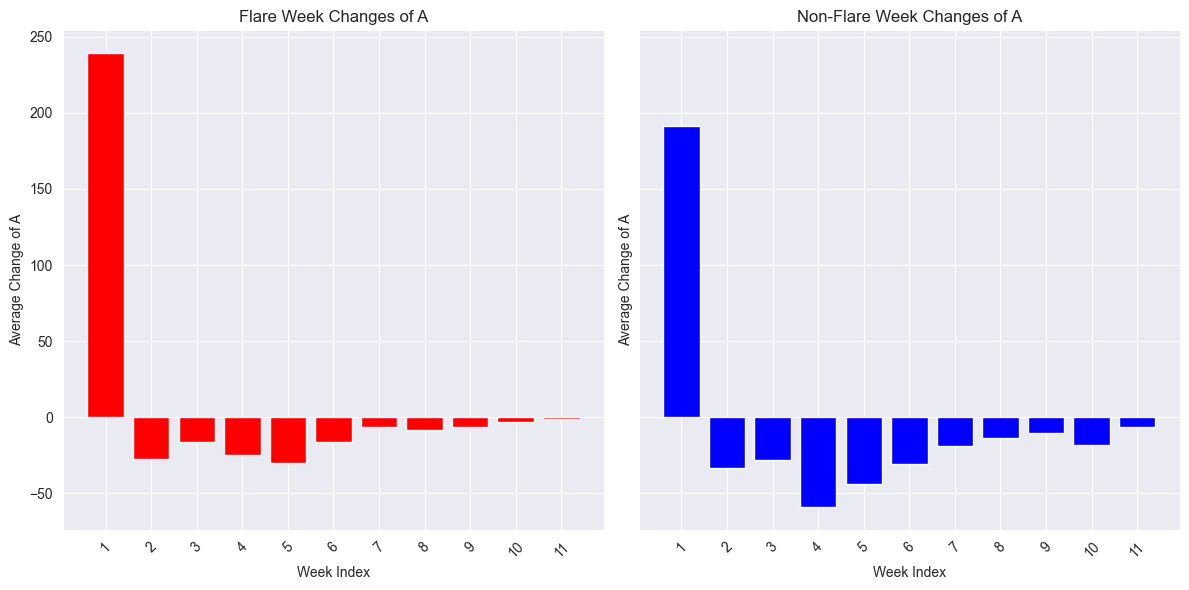

In [54]:
# calling function to plot and compare avg weekly change of DC
plot_average_change_between_flare_weeks(var_to_compare="A")